In [24]:
import random
import time
from math import ceil
from typing import Dict, Tuple
from typing import List, Set

import torch
from torch import Tensor
from torch import nn
from torch.utils.data import Dataset, DataLoader

import numpy as np

from graph import Graph
from part import Part
from node import Node
from preprocess import create_family_id_mapping
from mapping import FamilyIdMapper
from utils import load_graphs
from matplotlib import pyplot as plt
from tqdm import tqdm
from evaluation import edge_accuracy
from evaluation import normalized_relative_edge_accuracy

In [25]:
graphs = load_graphs()
mapping = create_family_id_mapping(graphs)
fam_mapping = FamilyIdMapper(graphs)

seed = 7
random.Random(seed).shuffle(graphs)

training_set_size_ratio = 0.8
validation_set_size_ratio = 0.03
test_size_ratio = 0.17

assert training_set_size_ratio + test_size_ratio + validation_set_size_ratio == 1

batch_size = 1024

input_size = 2 * len(mapping)  # 184
output_size = len(mapping)  # 92

input_size = input_size
hidden_size = 2 * input_size
output_size = output_size

learning_rate = 0.003
num_epochs = 50

In [26]:
def get_ofid(self):
    """
    :return: the original family if of the node's part
    """
    return int(self.get_part().get_family_id())


def get_dfid(self):
    """
    :return: the dense family if of the node's part
    """
    return fam_mapping.to_dense(get_ofid(self))


Node.get_ofid = get_ofid
Node.get_dfid = get_dfid

In [27]:
def create_features(graph: Graph, fam_mapping: FamilyIdMapper) -> Tuple[List[Tensor], List[Tensor]]:
    num_different_family_ids = fam_mapping.get_len()

    # Create a tensor for existing nodes and count their occurrences
    all_nodes_tensor = torch.zeros(num_different_family_ids, dtype=torch.float)
    nodes = graph.get_nodes()
    edges = graph.get_edges()

    feature_tensors = []
    target_tensors = []

    for node in nodes:
        dense_family_id = node.get_dfid()
        all_nodes_tensor[dense_family_id] += 1.0

        target_tensor = torch.zeros(num_different_family_ids, dtype=torch.float)
        for neighbour_node in edges[node]:
            neighbour_node_dense_family_id = neighbour_node.get_dfid()
            target_tensor[neighbour_node_dense_family_id] = 1
        target_tensors.append(target_tensor)

    for node in nodes:
        dense_family_id = node.get_dfid()
        given_node_tensor = torch.zeros(num_different_family_ids, dtype=torch.float)
        given_node_tensor[dense_family_id] = 1

        feature_tensors.append(torch.cat((all_nodes_tensor, given_node_tensor), dim=-1))

    return feature_tensors, target_tensors

In [28]:
# split data into train, val and test - they are already shuffled

train_upper = ceil(training_set_size_ratio * len(graphs))
val_upper = ceil((training_set_size_ratio + validation_set_size_ratio) * len(graphs))

train_graphs = graphs[0:train_upper]
val_graphs = graphs[train_upper:val_upper]
test_graphs = graphs[val_upper:len(graphs) + 1]


class GraphDataset(Dataset):
    def __init__(self, graphs: List[Graph]):
        x_list = []
        y_list = []
        for graph in graphs:
            x_per_graph, y_per_graph = create_features(graph, fam_mapping)
            x_list += x_per_graph
            y_list += y_per_graph
        self.x_tensor = torch.stack(x_list)
        self.y_tensor = torch.stack(y_list)
        self.n_samples = self.y_tensor.shape[0]

    def __getitem__(self, index):
        return self.x_tensor[index], self.y_tensor[index]

    def __len__(self):
        return self.n_samples


train_loader = DataLoader(
    dataset=GraphDataset(train_graphs),
    batch_size=batch_size,
    shuffle=True,
)
val_loader = DataLoader(
    dataset=GraphDataset(val_graphs),
    batch_size=batch_size,
    shuffle=False,
)

In [29]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        # self.fc2 = nn.Linear(..., ...)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        # x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x


st = time.time()

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.has_mps else "cpu")
model = Net().to(device)
n_total_steps = len(train_loader)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.BCELoss()
train_losses = []
val_losses = []

train_accuracies = []
val_accuracies = []

for epoch in tqdm(range(num_epochs), ascii="░▒█"):
    train_losses_per_epoch = 0.0
    train_accuracy_per_epoch = 0.0
    for i, (x_train, y_train) in enumerate(train_loader):
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        y_pred = model(x_train)
        loss = loss_fn(y_pred, y_train)
        train_losses_per_epoch += loss.cpu().detach().numpy()
        train_accuracy = torch.sum(y_train == y_pred.round()) / torch.numel(y_train)
        train_accuracy_per_epoch += train_accuracy.cpu().detach().numpy()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_losses.append(train_losses_per_epoch / len(train_loader))
    train_accuracies.append(train_accuracy_per_epoch / len(train_loader))

    with torch.no_grad():
        val_losses_per_epoch = 0.0
        val_accuracies_per_epoch = 0.0
        for i, (x_val, y_val) in enumerate(val_loader):
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            y_pred = model(x_val)
            loss = loss_fn(y_pred, y_val)
            val_accuracy = torch.sum(y_val == y_pred.round()) / torch.numel(y_val)
            val_losses_per_epoch += loss.cpu()
            val_accuracies_per_epoch += val_accuracy.cpu()
        val_losses.append(val_losses_per_epoch / len(val_loader))
        val_accuracies.append(val_accuracies_per_epoch / len(val_loader))

et = time.time()
print(f"Execution time: {(et - st):.2f}s")

100%|██████████| 50/50 [00:32<00:00,  1.52it/s]

Execution time: 32.86s


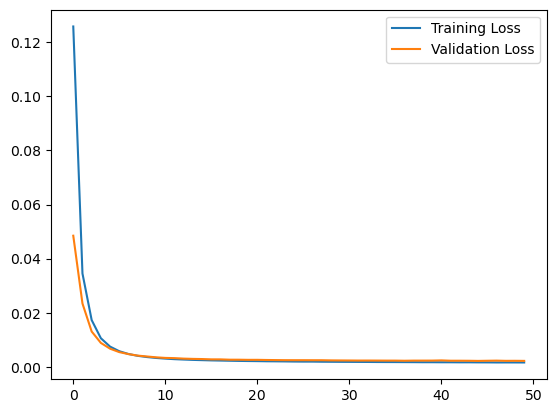

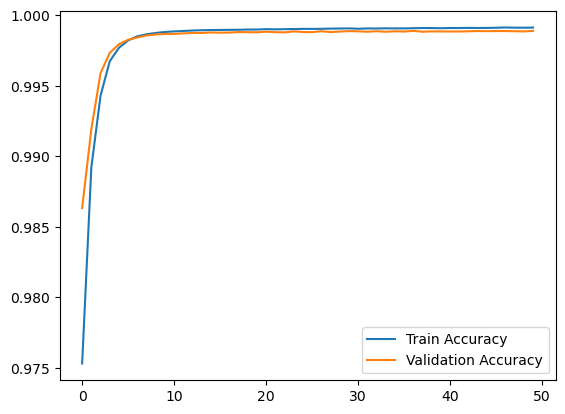

In [30]:
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.legend()
# plt.yscale('log')
plt.show()

plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.legend()
# plt.yscale('log')
plt.show()

In [31]:
def predict_graph_1(graph, model) -> Graph:
    # matrix dimensions: x = nodes_list index, y = dense family id
    predicted_adjacency_matrix = []
    result = Graph()
    x, y = create_features(graph, fam_mapping)
    for x_test, y_test in zip(x, y):
        y_test_pred = model(x_test)
        predicted_adjacency_matrix.append(y_test_pred)
    predicted_adjacency_matrix = torch.stack(predicted_adjacency_matrix)

    nodes = graph.get_nodes()
    nodes_list = list(nodes)
    node_count = len(nodes)
    added_nodes = set()
    last_rep_node_a_index = -1
    last_node_b_dense_family_id = -1
    result_edge_count = 0

    while True:
        max_pos_tensor = (predicted_adjacency_matrix == torch.max(predicted_adjacency_matrix)).nonzero()
        rep_node_a_index = max_pos_tensor[0][0].item()
        node_b_dense_family_id = max_pos_tensor[0][1].item()

        if rep_node_a_index == last_rep_node_a_index and node_b_dense_family_id == last_node_b_dense_family_id:
            break
        last_rep_node_a_index = rep_node_a_index
        last_node_b_dense_family_id = node_b_dense_family_id

        node_a_family_id = nodes_list[rep_node_a_index].get_ofid()
        node_b_family_id = fam_mapping.to_orig(node_b_dense_family_id)
        node_a_dense_family_id = fam_mapping.to_dense(node_a_family_id)

        for node_a_index, node_a in enumerate(nodes_list):
            if node_a.get_ofid() == node_a_family_id:
                for node_b_index, node_b in enumerate(nodes_list):
                    if node_b.get_ofid() == node_b_family_id:
                        if not (node_a in added_nodes and node_b in added_nodes):
                            result.add_undirected_edge(node_a.get_part(), node_b.get_part())
                            result_edge_count += 1
                            added_nodes.add(node_a)
                            added_nodes.add(node_b)
                            break

                        # non-necessary performance optimization
                        predicted_adjacency_matrix[node_a_index][node_b_dense_family_id] = 0.0
                        predicted_adjacency_matrix[node_b_index][node_a_dense_family_id] = 0.0
        predicted_adjacency_matrix[rep_node_a_index][node_b_dense_family_id] = 0.0
        if result_edge_count == node_count - 1:
            break
    return result

st = time.time()

edge_accuracies = []
cpu_model = model.cpu()

with torch.no_grad():
    with tqdm(val_graphs) as val_graphs_with_progress:
        for index, test_graph in enumerate(val_graphs_with_progress):
            predicted_graph = predict_graph_1(test_graph, cpu_model)
            graph_edge_accuracy = normalized_relative_edge_accuracy(test_graph, predicted_graph)
            # print(f"edge_accuracy: {graph_edge_accuracy}")
            # test_graph.draw()
            # predicted_graph.draw()
            # print("----")

            edge_accuracies.append(graph_edge_accuracy)
print(f"Edge accuracy: {sum(edge_accuracies) / len(edge_accuracies)}")

100%|██████████| 334/334 [00:16<00:00, 20.48it/s]

Edge accuracy: 0.8826195039452353


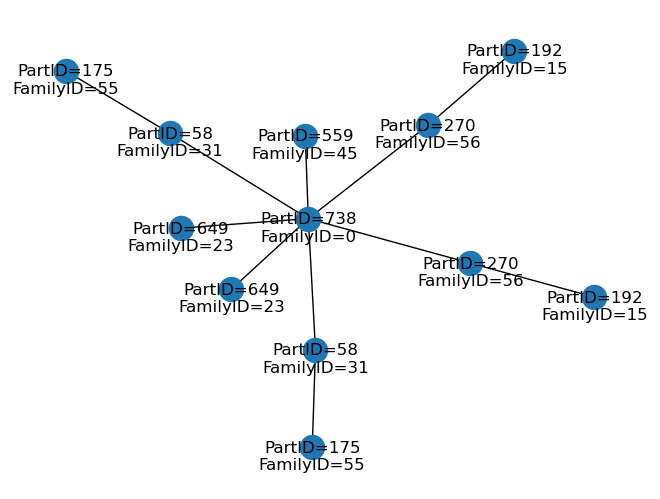

In [32]:
val_graphs[4].draw()

In [33]:
cpu_model = model.cpu()


def check_for_cycle(graph: Graph, source: Part, sink: Part):
    graph.add_undirected_edge(source, sink)
    return graph.is_cyclic()


def get_nodes_with_fam_id(nodes: List[Node], fam_id: int) -> List[Node]:
    return [node for node in nodes if node.get_ofid() == fam_id]


def get_least_fam_id_neighbours_node(graph: Graph, nodes: List[Node], fam_id: int) -> Node:
    balance_counts = [0] * len(nodes)
    for i, node in enumerate(nodes):
        edges = graph.get_edges().get(node)
        if edges is not None:
            balance_counts[i] = \
                sum(1 if n.get_ofid() == fam_id else 0 for n in edges)

    balanced_node_idx: int = np.array(balance_counts).argmin()
    node = nodes[balanced_node_idx]
    return node


def predict_graphs(graphs: List[Graph], fam_mapping: FamilyIdMapper, draw=False):
    edge_accuracies = []
    with torch.no_grad():
        with tqdm(graphs) as graphs_with_progress:
            for graph in graphs_with_progress:
                raw_predictions = []
                x, y = create_features(graph, fam_mapping)
                for x_test, y_test in zip(x, y):
                    y_test_pred = cpu_model(x_test)
                    raw_predictions.append(y_test_pred)
                raw_predictions = torch.stack(raw_predictions)

                predicted_graph = build_predicted_graph(graph, raw_predictions, fam_mapping)

                graph_edge_accuracy = normalized_relative_edge_accuracy(graph, predicted_graph)
                if draw:
                    print(f"edge_accuracy: {graph_edge_accuracy}")
                    graph.draw()
                    predicted_graph.draw()
                    print("----")

                edge_accuracies.append(graph_edge_accuracy)
    print(f"Mean edge accuracy: {sum(edge_accuracies) / len(edge_accuracies)}")


def build_predicted_graph(input_graph: Graph, pred_adj_matrix: Tensor, fam_mapping: FamilyIdMapper) -> Graph:
    nodes = input_graph.get_nodes()
    nodes_list = list(nodes)
    added_nodes = set()
    predicted_graph = Graph()

    while predicted_graph.get_edge_count() // 2 < input_graph.get_node_count() - 1 and not torch.all(
            pred_adj_matrix < 1e-3):
        max_signal_idx = (pred_adj_matrix == torch.max(pred_adj_matrix)).nonzero()
        source_node_idx = max_signal_idx[0][0].item()
        sink_dense_fam_id = max_signal_idx[0][1].item()

        source_orig_fam_id = nodes_list[source_node_idx].get_ofid()
        sink_orig_fam_id = fam_mapping.to_orig(sink_dense_fam_id)

        nodes_with_source_fam_id = get_nodes_with_fam_id(nodes_list, source_orig_fam_id)
        nodes_with_sink_fam_id = get_nodes_with_fam_id(nodes_list, sink_orig_fam_id)

        for source in nodes_with_source_fam_id:
            for sink in nodes_with_sink_fam_id:
                if not (source in added_nodes and sink in added_nodes):
                    predicted_graph.add_undirected_edge(source.get_part(), sink.get_part())
                    added_nodes.add(source)
                    added_nodes.add(sink)
                    break

        pred_adj_matrix[source_node_idx][sink_dense_fam_id] = 0.0

    return predicted_graph


st = time.time()
predict_graphs(val_graphs, fam_mapping, draw=False)
et = time.time()
print(f"Execution time: {(et - st):.2f}s")

100%|██████████| 334/334 [00:14<00:00, 23.38it/s]

Mean edge accuracy: 0.880210037164511
Execution time: 14.29s
